In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt

from _basicClasses import TimeSeriesDatasetSingleSubject, GlobalModel, LocalModel, EventModel, TimeSeriesDataset
from _train_pred import predict, evaluate, train, split_dataset
import glob
import pandas as pd
import os

In [2]:
import orjson
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas


In [3]:
K = 5  # Number of final factors 
# Parameters for the dataset
# J = 5 # Number of subjects
D = 321  # Number of features
T = 21044   # Number of time points
C = 1   # Number of categorical variables
C_levels = 3
num_epochs = 100  # Number of epochs for training
hidden_size_global = 100 
hidden_size_local = 5
train_ratio=.8
batch_size = 32

In [4]:


csv_directory = './electricity_data_files/'  

# Initialize a list to hold all time series data
all_series = []

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_directory, '*.csv'))

for file_path in csv_files:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Assuming 'traffic_volume' is the column with your time series data
    series = df['electricity_level'].values

    series = (series - series.mean())/series.std()
    
    # Convert the series to a PyTorch tensor and add a dimension to make it (T, 1)
    tensor_series = torch.tensor(series, dtype=torch.float32).unsqueeze(1)
    
    # Append the tensor to the list
    all_series.append(tensor_series)

# Concatenate all series along the first dimension to create a (T, D) tensor
X = torch.cat(all_series, dim=1)

# X is now a tensor of shape (T, D) where T is the total length of all series combined and D=1
print(X.shape)


torch.Size([21044, 321])


In [5]:
print(X[:,100].shape)
Y = X[:,100]
binary_events =  torch.zeros(T, 1)
cat_vars = torch.zeros(T, 1)
dataset = TimeSeriesDatasetSingleSubject(X[:-1], Y[:-1], X[1:], Y[1:], cat_vars, binary_events)

torch.Size([21044])


In [6]:

train_dataset, test_dataset = split_dataset(dataset, r=0.2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [7]:
len(test_dataset)

4209

In [8]:
# Assuming the model instances are created like this:
global_model = GlobalModel(D, hidden_size_global, K)

# 1 + num_categorical_features: 
local_model = LocalModel(1 + C, hidden_size_local)
# event_model = EventModel(C, hidden_dim= 10)
event_model = EventModel(1 + C, hidden_size_local)

optimizer = torch.optim.Adam(list(global_model.parameters()) + list(local_model.parameters()) + list(event_model.parameters()), lr=0.005)


In [9]:

# For early stopping
patience = 10
min_loss = float('inf')
best_model = None
best_epoch = 0

for epoch in range(num_epochs):
    train_loss = train(global_model, local_model, event_model, optimizer, train_dataloader)
    test_loss = evaluate(global_model, local_model, event_model, test_dataloader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1, Train Loss: 1.6749, Test Loss: 1.1609
Epoch 2, Train Loss: 1.1458, Test Loss: 1.3196
Epoch 3, Train Loss: 1.0613, Test Loss: 1.3158
Epoch 4, Train Loss: 0.9820, Test Loss: 1.3131
Epoch 5, Train Loss: 0.9431, Test Loss: 1.0657
Epoch 6, Train Loss: 0.9161, Test Loss: 0.9680
Epoch 7, Train Loss: 0.8680, Test Loss: 1.1109
Epoch 8, Train Loss: 0.8471, Test Loss: 1.0586
Epoch 9, Train Loss: 0.8201, Test Loss: 1.5606
Epoch 10, Train Loss: 0.8130, Test Loss: 1.1455
Epoch 11, Train Loss: 0.8018, Test Loss: 1.3579
Epoch 12, Train Loss: 0.7920, Test Loss: 1.0007
Epoch 13, Train Loss: 0.7917, Test Loss: 1.1845
Epoch 14, Train Loss: 0.8037, Test Loss: 1.0654
Epoch 15, Train Loss: 0.7784, Test Loss: 1.1443
Epoch 16, Train Loss: 0.8061, Test Loss: 1.1681
Epoch 17, Train Loss: 0.7721, Test Loss: 1.6946
Epoch 18, Train Loss: 0.7834, Test Loss: 1.1186
Epoch 19, Train Loss: 0.7721, Test Loss: 1.1671
Epoch 20, Train Loss: 0.7582, Test Loss: 1.1327
Epoch 21, Train Loss: 0.7747, Test Loss: 1.6189
E

In [10]:
W = (global_model).get_weight_matrix()
print(W)

Parameter containing:
tensor([-0.0011, -0.0060, -0.0504,  0.0049, -0.0049], requires_grad=True)


In [11]:
A = global_model.get_loading_matrix()
print(A)

Parameter containing:
tensor([[-0.0134, -0.0463,  0.0082,  ..., -0.0026,  0.0697,  0.0709],
        [-0.0041,  0.0309, -0.0352,  ...,  0.0051,  0.0072,  0.0176],
        [ 0.0075, -0.0004, -0.0028,  ...,  0.0012, -0.0097,  0.0097],
        [ 0.0334, -0.0238,  0.0209,  ..., -0.0187,  0.0312,  0.0029],
        [-0.0652, -0.0037, -0.0357,  ...,  0.0176, -0.0293, -0.0123]],
       requires_grad=True)


In [12]:

# Assuming you've already loaded your test DataLoader: test_dataloader
mus, sigmas, p_collected, z_collected, true_values, binary_events  = predict(global_model, local_model, event_model, test_dataloader)

# Convert to numpy for easier handling
mus_np = mus.numpy()
sigmas_np = sigmas.numpy()
p_collected = p_collected.numpy()
z_collected = z_collected.numpy()

true_values_np = true_values.numpy()
binary_events_np = binary_events.numpy()



In [13]:
# print(mus.shape, mus)
# print(sigmas.shape, sigmas)
# print(p_collected.shape, p_collected)
# print(true_values)
# print(binary_events_np)
print(p_collected[:,0])

[4.7550630e-11 1.4037694e-11 1.3999592e-11 ... 1.3999751e-11 1.3999618e-11
 1.3999404e-11]


In [14]:
binary_events


tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

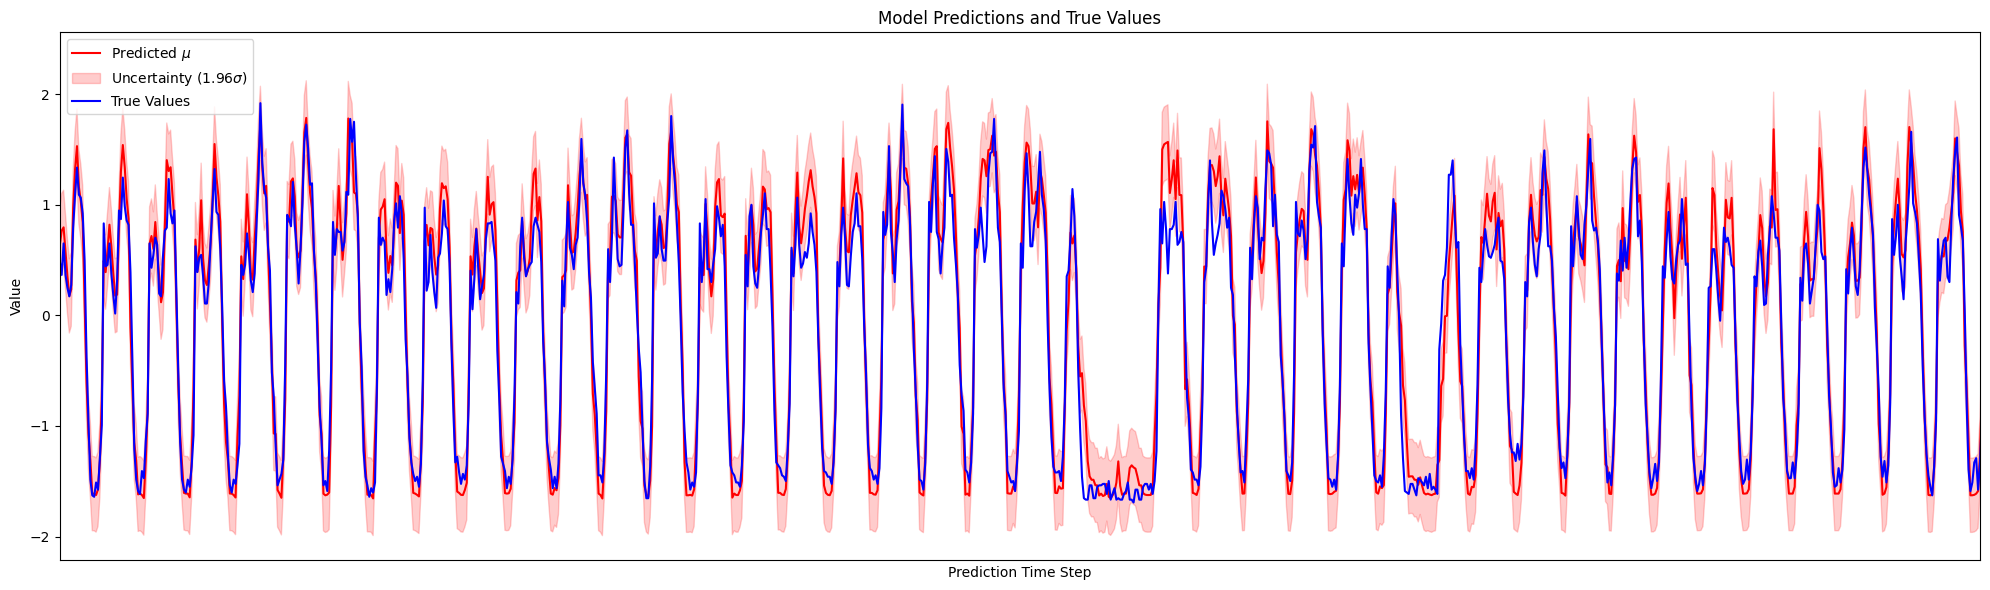

In [15]:
mus_subject = mus_np[:,]
sigmas_subject = sigmas_np[:,0]
true_values_subject = true_values_np
binary_events_subject = binary_events_np
p_subject = p_collected[:,0] # Extracted probabilities


plt.figure(figsize=(20, 6))
plt.plot(mus_subject, label='Predicted $\mu$', color='red')
plt.fill_between(range(len(mus_subject)), (mus_subject - 1.96 * sigmas_subject), (mus_subject + 1.96 * sigmas_subject), color='red', alpha=0.2, label='Uncertainty ($1.96\sigma$)')
plt.plot(true_values_subject, label='True Values', color='blue')

# Plotting the probability as a bar plot at the bottom
bar_height = p_subject  # Scaling factor for visibility
bar_bottom = np.min(true_values_subject)    # Adjust bottom to avoid overlap
# plt.bar(range(len(p_subject)), bar_height,  bottom=bar_bottom, color='gray', label='Event Pred. Probability', width=0.8)

# for i, (value, event) in enumerate(zip(true_values_subject, binary_events_subject)):
#     if event == 1:
#         plt.plot(i, value, 'x', color='black', markersize=8, label='Event = 1' if i == 0 else "")

plt.xticks(range(len(binary_events_subject)))
plt.xlabel('Prediction Time Step')
plt.ylabel('Value')
plt.title('Model Predictions and True Values')
plt.xticks([])

# plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, label='Threshold')
# Adjust y-axis limit to make space for the bar plot
# plt.ylim([np.min(bar_bottom)-.5, np.max(true_values_subject) + 1.2])
plt.xlim([0,1005])
# Legend
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure unique labels
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()
